In [3]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [4]:
#Define train and val directory
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
validation_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/'

#Directories of individual category
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

# Check the number of images for each class and set
print(f"train normal: {len(os.listdir(train_normal_dir))} \n")
print(f"train pneumonia: {len(os.listdir(train_pneumonia_dir))} \n")
print(f"validation normal: {len(os.listdir(validation_normal_dir))} \n")
print(f"validation pneumonia: {len(os.listdir(validation_pneumonia_dir))} \n")

train normal: 1341 

train pneumonia: 3875 

validation normal: 8 

validation pneumonia: 8 



Normal image:


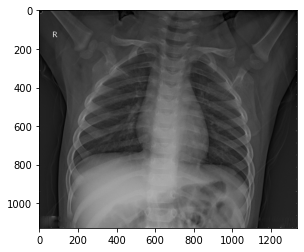


Pneumonia image:


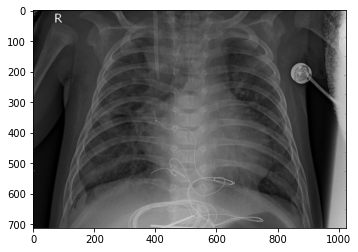

In [5]:
"""Check image"""
print("Normal image:")
plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])}"))
plt.show()

print("\nPneumonia image:")
plt.imshow(load_img(f"{os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[0])}"))
plt.show()

In [6]:
"""Check images shape"""
for i in range(10):
    sample_image  = load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[i])}")
    sample_array = img_to_array(sample_image)
    print(f"No.{i} image has shape: {sample_array.shape}")

No.0 image has shape: (1128, 1336, 3)
No.1 image has shape: (1260, 1400, 3)
No.2 image has shape: (1032, 1218, 3)
No.3 image has shape: (1433, 1782, 3)
No.4 image has shape: (1129, 1574, 3)
No.5 image has shape: (1345, 1744, 3)
No.6 image has shape: (1272, 1844, 3)
No.7 image has shape: (1249, 1500, 3)
No.8 image has shape: (2121, 2400, 3)
No.9 image has shape: (1102, 1338, 3)


In [7]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode="binary",
                                                      target_size=(150, 150)
                                                     )

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode="binary",
                                                                target_size=(150, 150) 
                                                               )
  return train_generator, validation_generator

#Test generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-10-04 05:49:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 108.177.11.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   171MB/s    in 0.5s    

2022-10-04 05:49:40 (171 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False


  return pre_trained_model

In [11]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

2022-10-04 05:49:40.456909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 05:49:40.557585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 05:49:40.558367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 05:49:40.560395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [13]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer("mixed7")
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [14]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [15]:
def create_final_model(pre_trained_model, last_output):

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation="relu")(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)  
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation="sigmoid")(x)        

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  
  return model

In [16]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [17]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

2022-10-04 05:49:45.983045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-04 05:49:50.577061: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 - 99s - loss: 0.1402 - accuracy: 0.9502 - val_loss: 0.0968 - val_accuracy: 1.0000
Epoch 2/100
163/163 - 57s - loss: 0.0626 - accuracy: 0.9768 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 3/100
163/163 - 57s - loss: 0.0417 - accuracy: 0.9864 - val_loss: 0.0440 - val_accuracy: 1.0000
Epoch 4/100
163/163 - 56s - loss: 0.0327 - accuracy: 0.9879 - val_loss: 0.0623 - val_accuracy: 0.9375
Epoch 5/100
163/163 - 56s - loss: 0.0270 - accuracy: 0.9908 - val_loss: 0.1955 - val_accuracy: 0.9375
Epoch 6/100
163/163 - 57s - loss: 0.0130 - accuracy: 0.9948 - val_loss: 0.1362 - val_accuracy: 0.9375
Epoch 7/100
163/163 - 57s - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.2302 - val_accuracy: 0.9375
Epoch 8/100
163/163 - 57s - loss: 0.0125 - accuracy: 0.9952 - val_loss: 0.2594 - val_accuracy: 0.9375
Epoch 9/100
163/163 - 56s - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.1062 - val_accuracy: 0.9375
Epoch 10/100
163/163 - 56s - loss: 0.0025 - accuracy: 0.9990 - val_loss: 0.0237 - val_accuracy

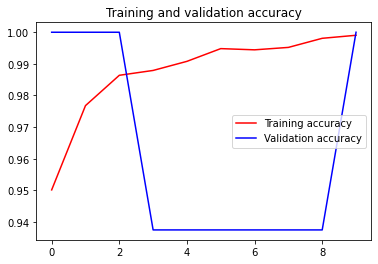

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [19]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

In [22]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory= test_dir,
                                                      batch_size=32, 
                                                      class_mode="binary",
                                                      target_size=(150, 150)
                                                     )

scores = model.evaluate(test_generator)

Found 5216 images belonging to 2 classes.
163/163 [==============================] - 56s 344ms/step - loss: 4.7891e-04 - accuracy: 0.9998
